In [5]:
import alphashape
from descartes import PolygonPatch
import geopandas as gpd
import pandas as pd
from geopy.geocoders import Nominatim
from ipywidgets import interact, fixed, widgets
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
from shapely import geometry
import plotly
import plotly.express as px

In [36]:
import contextily as cx
import colorcet


def plot_map(df_):
    """Plots the geometries of a geodataframe (df_)"""
    crs_ = df_.crs
    cdf = df_.copy()
            
    ax = cdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
    return cx.add_basemap(ax, crs=crs_)

In [86]:
address = 'Los Pelues 65, Valdivia'
geocoder = Nominatim(user_agent='Isochrone calculator')
location = geocoder.geocode(address)
location

Location(Los Pelúes, Isla Teja, Villa Endesa, Valdivia, Provincia de Valdivia, Región de Los Ríos, 5110655, Chile, (-39.8151793, -73.2579753, 0.0))

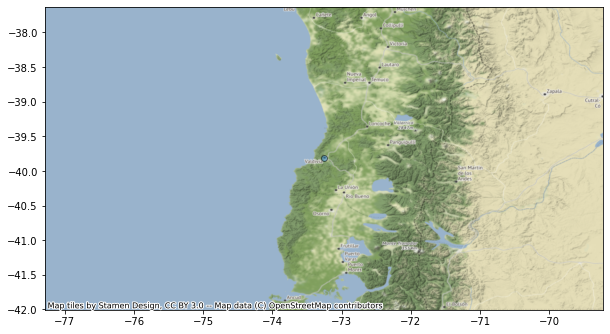

In [87]:
uni = gpd.tools.geocode(address, Nominatim, user_agent="Isochone Calculator")
plot_map(uni)


In [88]:
buffer = uni.to_crs(9155).buffer(2500).to_crs(4326)

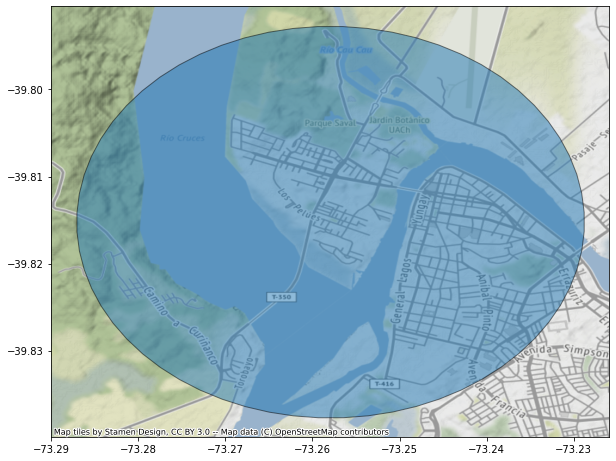

In [89]:
plot_map(buffer)

In [90]:
bounds = buffer.bounds.iloc[0]
bounds

minx   -73.287103
miny   -39.837642
maxx   -73.228846
maxy   -39.792716
Name: 0, dtype: float64

In [91]:
region = ox.graph_from_bbox(bounds["maxy"],
                            bounds["miny"],
                            bounds["minx"],
                            bounds["maxx"])

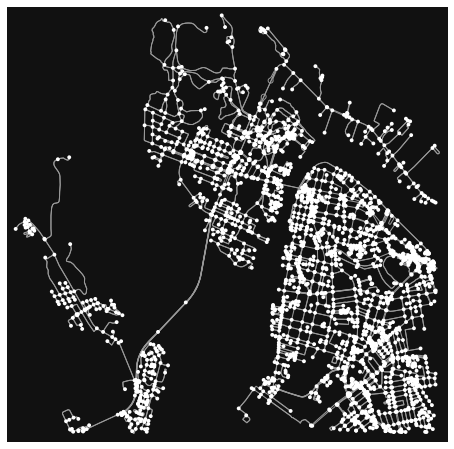

(<Figure size 576x576 with 1 Axes>, <AxesSubplot: >)

In [92]:
ox.plot_graph(region)

In [93]:
center_node = ox.distance.nearest_nodes(region, Y=uni.loc[0, "geometry"].y, X=uni.loc[0, "geometry"].x)
center_node

1181391918

In [94]:
region = ox.project_graph(region, 9155)

In [95]:
distances = np.arange(0, 60, 1)
iso_colors = ox.plot.get_colors(n=len(distances), cmap='plasma', start=0, return_hex=True)

60it [00:01, 32.17it/s]


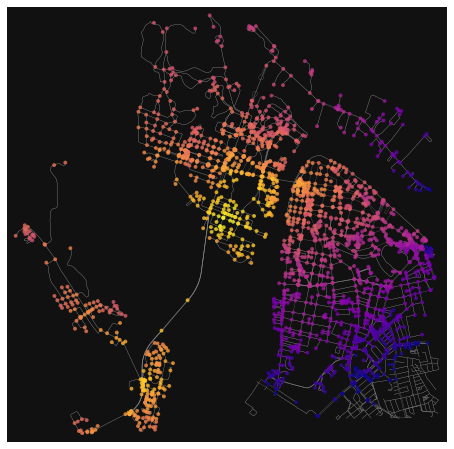

In [96]:
from tqdm import tqdm 

node_colors = {}

for trip_time, color in tqdm(zip(sorted(distances, reverse=True), iso_colors)):
    subgraph = nx.ego_graph(region, center_node, radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color


nc = [node_colors[node] if node in node_colors else "none" for node in region.nodes()]
ns = [15 if node in node_colors else 0 for node in region.nodes()]

fig, ax = ox.plot_graph(region, node_color=nc, node_size=ns, node_alpha=0.8,
                        edge_linewidth=0.2, edge_color="#999999")

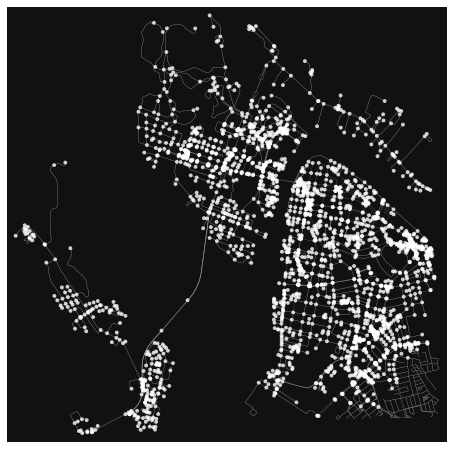

In [97]:
subgraph = nx.ego_graph(region, center_node, radius=60, distance='time')
nc = ["white" if node in subgraph else "none" for node in region.nodes()]
ns = [15 if node in subgraph else 0 for node in region.nodes()]

fig, ax = ox.plot_graph(region, node_color=nc, node_size=ns, node_alpha=0.8,
                        edge_linewidth=0.2, edge_color="#999999")

In [102]:
points = pd.DataFrame([(data['x'], data['y']) for _, data in subgraph.nodes(data=True)], columns=['x', 'y'])
geopoints = gpd.GeoSeries(points.apply(geometry.Point, axis=1))
geopoints.crs = 9155
geopoints.head()

/Users/martincontreras/miniforge3/envs/geo/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



0    POINT (134033.038 5582733.370)
1    POINT (133883.541 5582939.188)
2    POINT (134108.815 5582694.237)
3    POINT (133841.289 5582917.598)
4    POINT (137836.490 5584489.850)
dtype: geometry

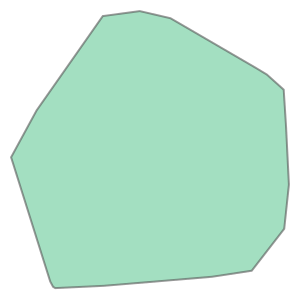

In [103]:
geopoints.unary_union.convex_hull

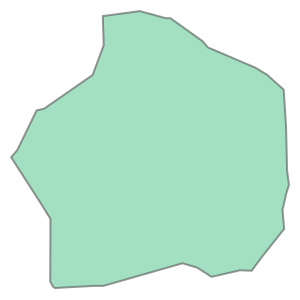

In [109]:
alphashape.alphashape(geopoints, alpha=0.001)

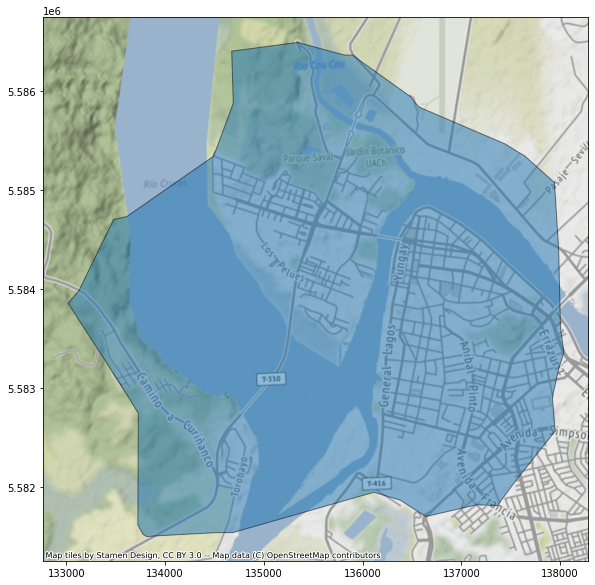

In [126]:
poly = gpd.GeoDataFrame(geometry=[alphashape.alphashape(geopoints, alpha=0.001)], crs=9155)

plot_map(poly)